In [1]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

%load_ext autoreload
%autoreload
from functions_economic_analysis import *

In [2]:
datacsv          = "peru_clusters_july/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsv)

In [3]:
figures = "figures_new/"
if not os.path.exists(figures):
    os.makedirs(figures)

In [4]:
baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(2))

### calculates weights for each node

In [5]:
nodes1 = read_excel(data_peru+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_peru+"NODES_10km_TPDA.xlsx","NODES_10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [6]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

In [7]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [8]:
info_links = read_excel(data_peru+"Traffic_Link_Final_PER_jun03.xlsx","Traffic_Link_Final")
huaycos = read_csv("huaycos peru/Traffic_Link_Final_huaycos.csv")
huaycos.index = huaycos.ScenarioID
info_links["huaycos"] = huaycos.Huaycos
#info_links = read_excel(datacsv+"allinfo.xlsx","Traffic_Link_AllInfo")

In [9]:
cluster_americana   = read_csv(datacsv+"links_Cluster_Americana.csv")
cluster_americanav2 = read_csv(datacsv+"links_Cluster_Americanav2.csv")
cluster_central     = read_csv(datacsv+"links_Cluster_Central.csv")
cluster_centralv2   = read_csv(datacsv+"links_Cluster_Centralv2.csv")
cluster_norte       = read_csv(datacsv+"links_Cluster_Norte.csv")

In [10]:
costs_all = DataFrame(columns=["scenarioID","partial_or_full","part_ruc_increase","ruc_increase","missingroutes",\
                           "num_aff_routes","cost_with_traffic","km_diff","improved_2nd"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "second_best" in file:
        continue
    if file=="OD_baseline_Peru.csv":
        continue
    if ("links" in file):
        continue
    if "alt" in file:
        improved_2nd=1
        if ("partial" in file):
            partial_or_full="partial"
            n      = (re.search('Cluster_(.*)_alt_partial.csv', file).group(1))
            part_ruc_increase = 0.5
        if ("full" in file):
            partial_or_full='full'
            n      = (re.search('Cluster_(.*)_alt_full.csv', file).group(1))
            part_ruc_increase = 0.
    else:
        improved_2nd=0
        if ("partial" in file):
            partial_or_full="partial"
            n      = (re.search('Cluster_(.*)_partial.csv', file).group(1))
            part_ruc_increase = 0.5
        if ("full" in file):
            partial_or_full='full'
            n      = (re.search('Cluster_(.*)_full.csv', file).group(1))
            part_ruc_increase = 0.
    scenar = read_csv(datacsv+file)
    scenar.index = scenar.Name

    missingroutes = len(baseline)-len(scenar)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r>0)
    subscenar = scenar.ix[affected_routes,:]
    subscenar["weights"] = baseline_nm.weights

    traffic = info_links.ix[eval("cluster_"+n).ScenarioID,"TPDA"].max()

    diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                           baseline_nm.ix[affected_routes,"Total_Ta_r"])
    diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
    diff_tot_baseline   = (traffic*diff_ruc_baseline)

    ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
    km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
    cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

    costs_all.loc[len(costs_all),:] = [n,partial_or_full,part_ruc_increase,\
                                       ruc_increase,missingroutes,sum(affected_routes),\
                                       cost_with_traffic,km_diff,improved_2nd]

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
costs_all

,scenarioID,partial_or_full,part_ruc_increase,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff,improved_2nd
0,americanav2,full,0,500.5789,0,1874,3456998,296.5262,0
1,americanav2,partial,0.5,25.09813,0,1874,173327.7,1.214317,0
2,americana,full,0,500.5789,0,1874,3456998,296.5262,1
3,americana,partial,0.5,66.3984,0,1874,458547.4,1.264225,1
4,americana,full,0,500.5789,0,1874,3456998,296.5262,0
5,americana,partial,0.5,425.4247,0,1874,2937983,89.52628,0
6,centralv2,full,0,1.892001,180,1764,10519.52,1.218482,1
7,centralv2,partial,0.5,-0.6941163,0,1846,-3859.287,0.02429041,1
8,centralv2,full,0,73.79377,180,368,410293.4,26.89949,0
9,centralv2,partial,0.5,3.43787,0,412,19114.56,-0.02860785,0


In [12]:
scenar = read_csv(datacsv+"Cluster_centralv2_full.csv")
scenar.index = scenar.Name
missing_routes = [r not in scenar.Name for r in baseline.Name]

In [13]:
sum(missing_routes)

180

In [14]:
origins = baseline.ix[missing_routes,"Name"].apply(lambda s: re.search("(.*) - (.*)",s).group(1))
cuts = origins.value_counts()

In [15]:
print(cluster_americanav2.KM.sum())
print(cluster_centralv2.KM.sum())
print(cluster_norte.KM.sum())

22.714298648
17.5669707981
30.9548088806


In [16]:
info_links.columns

Index(['ScenarioID', 'NAME_0', 'STATUS', 'INTERVEN', 'CLASS', 'LANES', 'TPDA',
       'OD', 'CODIGO', 'CORR_ID', 'KM', 'TID', 'pop', 'CITY_NAME',
       'ADMIN_NAME', 'CNTRY_NAME', 'STATUS.1', 'TERRAIN', 'SURFACE1', 'COND1',
       'TRAFFIC', 'Ta_ruc', 'Ta_voc', 'OPTIMAL', 'EU_historical_RP5 (dm)',
       'EU_historical_RP10 (dm)', 'EU_historical_RP25 (dm)',
       'EU_historical_RP50 (dm)', 'EU_historical_RP100 (dm)',
       'EU_historical_RP250 (dm)', 'EU_historical_RP500 (dm)',
       'EU_historical_RP1000 (dm)', 'GFDL_8.5_RP5 (dm)', 'GFDL_8.5_RP10 (dm)',
       'GFDL_8.5_RP25 (dm)', 'GFDL_8.5_RP50 (dm)', 'GFDL_8.5_RP100 (dm)',
       'GFDL_8.5_RP250 (dm)', 'GFDL_8.5_RP500 (dm)', 'GFDL_8.5_RP1000 (dm)',
       'HadGEM2_8.5_RP5 (dm)', 'HadGEM2_8.5_RP10 (dm)',
       'HadGEM2_8.5_RP25 (dm)', 'HadGEM2_8.5_RP50 (dm)',
       'HadGEM2_8.5_RP100 (dm)', 'HadGEM2_8.5_RP250 (dm)',
       'HadGEM2_8.5_RP500 (dm)', 'HadGEM2_8.5_RP1000 (dm)',
       'IPSL_8.5_RP5 (dm)', 'IPSL_8.5_RP10 (dm)', 'I

In [17]:
for n in ["americana","americanav2","central","norte","centralv2"]:
    for col in ["KM"]:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].sum()
    for col in ['Elevation (m)','TPDA']:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
            for RP in [5,10,25,50,100,250,500,1000]:
                col = "{}_RP{} (dm)".format(climat,RP)
                costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].max()
    for col in ['CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL', 'STATUS', 'SURFACE1','TERRAIN','OD']:
        costs_all.ix[costs_all.scenarioID==n,col]=info_links.ix[eval("cluster_"+n).ScenarioID,col].value_counts().index[0]

In [18]:
terrain_corr = read_csv("terrain_correspondance.csv")

In [19]:
costs_all = costs_all.merge(terrain_corr,on=["TERRAIN"],how="inner")

In [20]:
costs_all[['scenarioID','CLASS', 'COND1', 'Identifier',\
               'LANES', 'OPTIMAL','SURFACE1','TERRAIN','terrain2']]

,scenarioID,CLASS,COND1,Identifier,LANES,OPTIMAL,SURFACE1,TERRAIN,terrain2
0,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating,hilly
1,americanav2,Primary,Poor,Pan Americana,6,1,Paved,Winding and gently undulating,hilly
2,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly
3,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly
4,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly
5,americana,Primary,Poor,Pan Americana,6,1,Paved,Mostly straight and gently undulating,hilly
6,centralv2,Primary,Good,Carretera Central,6,1,Paved,Mostly straight and gently undulating,hilly
7,centralv2,Primary,Good,Carretera Central,6,1,Paved,Mostly straight and gently undulating,hilly
8,centralv2,Primary,Good,Carretera Central,6,1,Paved,Mostly straight and gently undulating,hilly
9,centralv2,Primary,Good,Carretera Central,6,1,Paved,Mostly straight and gently undulating,hilly


In [21]:
intervention_costs = read_csv("interventions_costs_usdperkm_sep1.csv")

In [22]:
costs_all = costs_all.merge(intervention_costs,on=["CLASS","SURFACE1","terrain2"],how="inner")

In [23]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
costs_all[['scenarioID','OD','terrain2']]

,scenarioID,OD,terrain2
0,americanav2,I.V. Santa Anita (Lim) - I.V. Pucusana - San Clemente (PE-28 A) - La Repartici├│n (Dv. Arequipa - PE-34 A) - Tacna (PE-38) - La Concordia (frontera con Chile),hilly
1,americanav2,I.V. Santa Anita (Lim) - I.V. Pucusana - San Clemente (PE-28 A) - La Repartici├│n (Dv. Arequipa - PE-34 A) - Tacna (PE-38) - La Concordia (frontera con Chile),hilly
2,americana,I.V. Santa Anita (Lim) - I.V. Pucusana - San Clemente (PE-28 A) - La Repartici├│n (Dv. Arequipa - PE-34 A) - Tacna (PE-38) - La Concordia (frontera con Chile),hilly
3,americana,I.V. Santa Anita (Lim) - I.V. Pucusana - San Clemente (PE-28 A) - La Repartici├│n (Dv. Arequipa - PE-34 A) - Tacna (PE-38) - La Concordia (frontera con Chile),hilly
4,americana,I.V. Santa Anita (Lim) - I.V. Pucusana - San Clemente (PE-28 A) - La Repartici├│n (Dv. Arequipa - PE-34 A) - Tacna (PE-38) - La Concordia (frontera con Chile),hilly
5,americana,I.V. Santa Anita (Lim) - I.V. Pucusana - San Clemente (PE-28 A) - La Repartici├│n (Dv. Arequipa - PE-34 A) - Tacna (PE-38) - La Concordia (frontera con Chile),hilly
6,centralv2,Emp. PE-1N (I.V. La Menacho) - I.V. Huachipa - Pte. Huachipa ? Dv. Sta. Anita - Sta. Clara - Chosica - Ricardo Palma - Pte. icardo Palma - Pte. ollana - Matucana - San Mateo -Morococha - Santa Rosa de Sacco - Emp. PE-3 (Repartici├│n La Oroya),hilly
7,centralv2,Emp. PE-1N (I.V. La Menacho) - I.V. Huachipa - Pte. Huachipa ? Dv. Sta. Anita - Sta. Clara - Chosica - Ricardo Palma - Pte. icardo Palma - Pte. ollana - Matucana - San Mateo -Morococha - Santa Rosa de Sacco - Emp. PE-3 (Repartici├│n La Oroya),hilly
8,centralv2,Emp. PE-1N (I.V. La Menacho) - I.V. Huachipa - Pte. Huachipa ? Dv. Sta. Anita - Sta. Clara - Chosica - Ricardo Palma - Pte. icardo Palma - Pte. ollana - Matucana - San Mateo -Morococha - Santa Rosa de Sacco - Emp. PE-3 (Repartici├│n La Oroya),hilly
9,centralv2,Emp. PE-1N (I.V. La Menacho) - I.V. Huachipa - Pte. Huachipa ? Dv. Sta. Anita - Sta. Clara - Chosica - Ricardo Palma - Pte. icardo Palma - Pte. ollana - Matucana - San Mateo -Morococha - Santa Rosa de Sacco - Emp. PE-3 (Repartici├│n La Oroya),hilly


rucs_typologies = read_excel("HDM4/descriptivesRUCS_baseline.xlsx","baselineRUCs_raw")
rucs_typologies.query("country_c=='Peru'").to_csv("descriptivesRUCS_Peru.csv",index=False)

In [24]:
rucs_typologies = read_csv("descriptivesRUCS_Peru.csv")

In [25]:
sb_americana = DataFrame()
sb_centralv2 = DataFrame()
sb_norte     = DataFrame()
sb_central   = DataFrame()
for file in list_csv:
    if "second_best" in file:
        second_best = read_csv(datacsv+file)
        aa = re.search("second_best_(.*)_(.*)_(.*).csv",file)
        link = aa.group(1).lower()
        exec("sb_"+link+"= sb_"+link+".append(second_best)")

In [26]:
sb_centralv2.columns

Index(['OBJECTID', 'NAME_0', 'CONDITION', 'STATUS', 'INTERVEN', 'CLASS',
       'SURF', 'SEASON', 'OFID', 'LANES', 'TPDA', 'OD', 'CODIGO', 'CORR_ID',
       'KM', 'jn_TRAFFIC', 'jn_CODIGO2', 'jn_AUTO', 'jn_BUS', 'jn_TRUCK',
       'TID', 'pop', 'CITY_NAME', 'ADMIN_NAME', 'CNTRY_NAME', 'STATUS_1',
       'BUFF_DIST', 'TERRAIN', 'SURFACE1', 'COUNTRY', 'COND1', 'TRAFFIC',
       'COUNTRY_C', 'CLASS_C', 'TERRAIN_C', 'SURFACE1_C', 'COND1_C',
       'TRAFFIC_C', 'LANES_C', 'JOIN', 'id', 'join_1', 'country__1', 'ruc',
       'voc', 'voc_fuel', 'voc_lub', 'voc_tire', 'voc_mpar', 'voc_mlab',
       'voc_crew', 'voc_dep', 'voc_int', 'voc_over', 'vot', 'vot_pass',
       'vot_cargo', 'tid_1', 'a_ruc', 'a_voc', 'a_vot', 'a_voc_fuel',
       'a_voc_lub', 'a_voc_tire', 'a_voc_mpar', 'a_voc_mlab', 'a_voc_crew',
       'a_voc_dep', 'a_voc_int', 'a_voc_over', 'a_vot_pass', 'a_vot_carg',
       'Ta_ruc', 'Ta_voc', 'OPTIMAL', 'Shape_Leng', 'huaycos', 'flood_25rp'],
      dtype='object')

In [27]:
print(sb_centralv2.KM.sum())
print(sb_norte.KM.sum())
print(sb_americana.KM.sum())

501.596151397
403.808832063
840.320346393


In [28]:
sb_centralv2[['CONDITION', 'STATUS','CLASS','SURFACE1', 'LANES', 'TPDA', 'KM','ruc','TRAFFIC','TERRAIN']].head()

,CONDITION,STATUS,CLASS,SURFACE1,LANES,TPDA,KM,ruc,TRAFFIC,TERRAIN
0,Bueno,In Operation,Primary,Paved,4,477,0.640292,1.201030,"300-1,000",Winding and gently undulating
1,Bueno,In Operation,Primary,Paved,4,477,4.935225,1.176618,"300-1,000",Mostly straight and gently undulating
2,Bueno,In Operation,Primary,Paved,4,477,4.662343,1.176618,"300-1,000",Mostly straight and gently undulating
3,Bueno,In Operation,Primary,Paved,4,816,15.663726,1.181549,"300-1,000",Bendy and gently undulating
4,Bueno,In Operation,Primary,Paved,4,816,4.253442,1.176618,"300-1,000",Mostly straight and gently undulating


In [29]:
for link in ["centralv2","americana","norte"]:
    exec("sb_"+link+" = sb_"+link+".merge(terrain_corr,on=['TERRAIN'],how='inner').merge(intervention_costs,on=['terrain2','SURFACE1','CLASS'],how='inner')")

In [30]:
sb_americana.groupby(['CLASS','SURF','CONDITION','LANES','TERRAIN']).count().NAME_0

CLASS      SURF       CONDITION  LANES  TERRAIN                              
Primary    Paved      Bueno      4      Mostly straight and gently undulating     1
                                        Winding and gently undulating             5
                                 6      Bendy and gently undulating               5
                                        Mostly straight and gently undulating     8
                                        Winding and gently undulating             9
                      Malo       4      Bendy and gently undulating               1
                                        Winding and gently undulating             1
                                        Winding and severely undulating           3
                                 6      Bendy and generally level                 8
                                        Mostly straight and gently undulating     2
                                        Straight and level                        

In [189]:
%load_ext autoreload
%autoreload
from functions_economic_analysis_cc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
a = get_water_level(costs_all,"norte",1,'EU_historical').append(get_water_level(costs_all,"norte",2,'EU_historical')).append(get_water_level(costs_all,"norte",3,'EU_historical'))

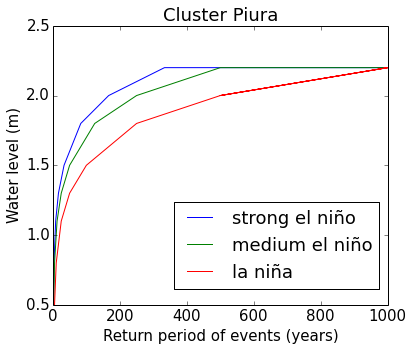

In [195]:
labels = ["","la niña","medium el niño","strong el niño"]
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,5))

ax=plt.subplot(111)
for p in a.proba.unique()[::-1]:
    sel = a.proba==p
    ax.plot(a.ix[sel,"return_period"],a.ix[sel,"water_level"]*0.1,label=labels[p])
ax.set_ylim([0.5,2.5])
ax.legend(bbox_to_anchor=(0.5,-0.1,0.5,0.5))
plt.xlabel("Return period of events (years)")
plt.ylabel("Water level (m)")
plt.title("Cluster Piura")
plt.savefig("figures_august/el_nino_piura.png",dpi=100)

In [62]:
panam = run_scenarios_floods(costs_all,"americana","bau")

In [222]:
central = run_scenarios_floods(costs_all,"centralv2","bau")
central = run_scenarios_huaycos_from_floods(central,costs_all,"centralv2","bau")

In [64]:
norte = run_scenarios_floods(costs_all,"norte","bau")

In [65]:
panam.head()

,intervention,redirection,proba,length,user_annual_losses,expost_annual_losses
0,bau,0,1,2,5.135301e+07,5.222764e+07
1,bau,0,2,2,1.02706e+08,1.044553e+08
2,bau,0,1,1,3.306549e+07,4.473666e+07
3,bau,0,2,1,6.613097e+07,8.947331e+07
4,bau,0,1,0.5,2.392173e+07,3.275108e+07


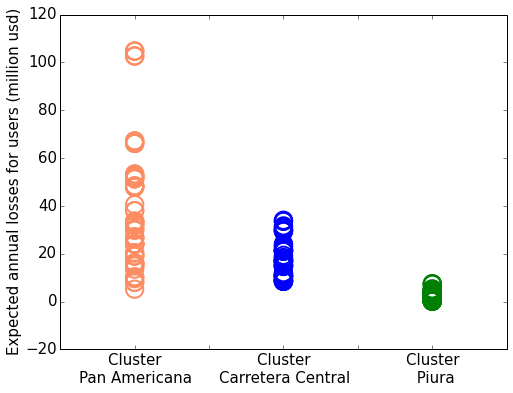

In [223]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([0]*len(panam.user_annual_losses),panam.user_annual_losses*10**(-6),\
                 marker='o',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([1]*len(central.user_annual_losses),central.user_annual_losses*10**(-6)+\
           central.losses_user_huyacos*10**(-6),\
                 marker='o',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.scatter([2]*len(norte.user_annual_losses),norte.user_annual_losses*10**(-6),\
                 marker='o',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.set_xlim([-0.5,2.5])
#ax.set_ylim([0,150])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Cluster \nPan Americana"
labelsx[3]="Cluster \nCarretera Central"
labelsx[5]="Cluster \n Piura"

ax.set_xticklabels(labelsx)

plt.ylabel("Expected annual losses for users (million usd)")

plt.savefig(figures+"EL_without_expost_intervention_nov9.png",bbox_inches="tight",dpi=100)

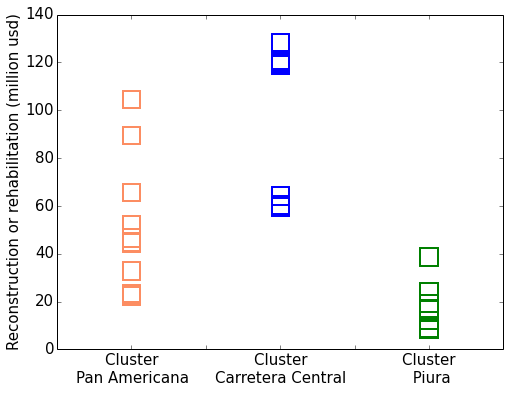

In [224]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([0]*len(panam.expost_annual_losses),panam.expost_annual_losses*10**(-6),\
                 marker='s',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([1]*len(central.expost_annual_losses),central.expost_annual_losses*10**(-6)+\
           central.losses_exposti_huycas*10**(-6),\
                 marker='s',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.scatter([2]*len(norte.expost_annual_losses),norte.expost_annual_losses*10**(-6),\
                 marker='s',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.set_xlim([-0.5,2.5])
#ax.set_ylim([0,150])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="Cluster \nPan Americana"
labelsx[3]="Cluster \nCarretera Central"
labelsx[5]="Cluster \n Piura"

ax.set_xticklabels(labelsx)

plt.ylabel("Reconstruction or rehabilitation (million usd)")

plt.savefig(figures+"EL_expost_intervention_nov9.png",bbox_inches="tight",dpi=100)

In [203]:
disc_rate = 0.03
years = 30
growth = 0.03

In [205]:
%load_ext autoreload
%autoreload
from functions_economic_analysis_cc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
panam_m = calc_npv_floods(years,costs_all,"americana","maintenance",disc_rate,sb_americana,growth=growth)

In [208]:
central_m = calc_npv_floods(years,costs_all,"centralv2","maintenance",disc_rate,sb_centralv2,growth=growth,plushuyacos=True)

In [209]:
norte_m = calc_npv_floods(years,costs_all,"centralv2","maintenance",disc_rate,sb_norte,growth=growth)

In [211]:
panam_r = calc_npv_floods(years,costs_all,"americana","redundancy",disc_rate,sb_americana,growth=growth)
norte_r = calc_npv_floods(years,costs_all,"norte","redundancy",disc_rate,sb_norte,growth=growth)

In [212]:
central_r = calc_npv_floods(years,costs_all,"centralv2","redundancy",disc_rate,sb_centralv2,growth=growth,plushuyacos=True)

In [213]:
panam_r2 = calc_npv_floods(years,costs_all,"americana","redundancy",disc_rate,sb_americana,growth=growth,pc_improvement=0.3)

In [214]:
panam_fp = calc_npv_floods(years,costs_all,"americana","flood_proof",disc_rate,sb_americana,growth=growth)

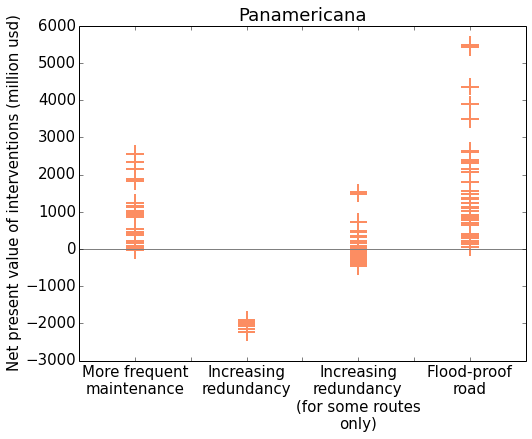

In [215]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([0]*len(panam_m.npv),panam_m.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([1]*len(panam_r.npv),panam_r.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([2]*len(panam_r2.npv),panam_r2.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.scatter([3]*len(panam_fp.npv),panam_fp.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='#fc8d62',linewidth='2')

ax.set_xlim([-0.5,3.5])
#ax.set_ylim([0,150])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="More frequent\nmaintenance"
labelsx[3]="Increasing\nredundancy"
labelsx[5]="Increasing\nredundancy\n(for some routes\nonly)"
labelsx[7]="Flood-proof\nroad"

ax.set_xticklabels(labelsx)

plt.plot([-0.5,3.5],[0,0],color="grey")

plt.ylabel("Net present value of interventions (million usd)")

plt.title("Panamericana")

plt.savefig(figures+"npv_americana_disc3_growth3.png",bbox_inches="tight",dpi=100)

In [216]:
central_r2 = calc_npv_floods(years,costs_all,"centralv2","redundancy",disc_rate,sb_centralv2,growth=growth,pc_improvement=0.3,plushuyacos=True)

In [217]:
central_fp = calc_npv_floods(years,costs_all,"centralv2","flood_proof",disc_rate,sb_centralv2,growth=growth)

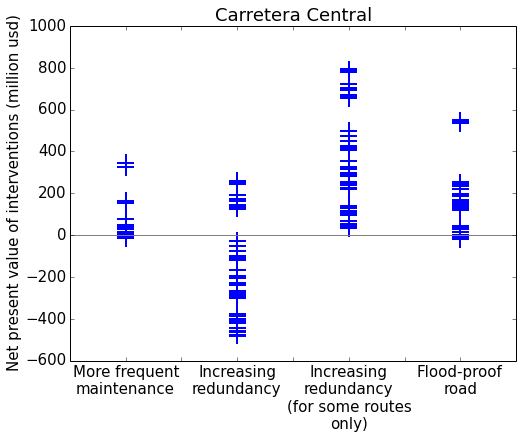

In [218]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([0]*len(central_m.npv),central_m.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.scatter([1]*len(central_r.npv),central_r.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.scatter([2]*len(central_r2.npv),central_r2.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.scatter([3]*len(central_fp.npv),central_fp.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='blue',linewidth='2')

ax.set_xlim([-0.5,3.5])
#ax.set_ylim([0,150])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="More frequent\nmaintenance"
labelsx[3]="Increasing\nredundancy"
labelsx[5]="Increasing\nredundancy\n(for some routes\nonly)"
labelsx[7]="Flood-proof\nroad"

ax.set_xticklabels(labelsx)

plt.plot([-0.5,3.5],[0,0],color="grey")

plt.ylabel("Net present value of interventions (million usd)")

plt.title("Carretera Central")

plt.savefig(figures+"npv_central_disc3_growth3.png",bbox_inches="tight",dpi=100)

In [219]:
norte_fp = calc_npv_floods(years,costs_all,"norte","flood_proof",disc_rate,sb_norte,growth=growth)

In [220]:
norte_r2 = calc_npv_floods(years,costs_all,"norte","redundancy",disc_rate,sb_norte,growth=growth,pc_improvement=0.3)

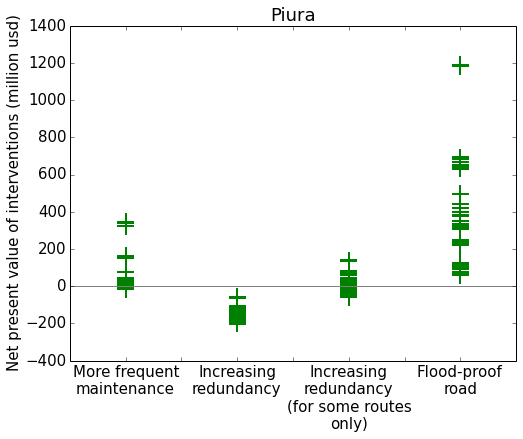

In [221]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))

ax=plt.subplot(111)

ax.scatter([0]*len(norte_m.npv),norte_m.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.scatter([1]*len(norte_r.npv),norte_r.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.scatter([2]*len(norte_r2.npv),norte_r2.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.scatter([3]*len(norte_fp.npv),norte_fp.npv*10**(-6),\
                 marker='+',s=300,facecolors='none',edgecolors='green',linewidth='2')

ax.set_xlim([-0.5,3.5])
#ax.set_ylim([0,150])

labelsx = [item.get_text() for item in ax.get_xticklabels()]
labelsx[1]="More frequent\nmaintenance"
labelsx[3]="Increasing\nredundancy"
labelsx[5]="Increasing\nredundancy\n(for some routes\nonly)"
labelsx[7]="Flood-proof\nroad"

ax.set_xticklabels(labelsx)

plt.plot([-0.5,3.5],[0,0],color="grey")

plt.ylabel("Net present value of interventions (million usd)")

plt.title("Piura")

plt.savefig(figures+"npv_norte_disc3_growth3.png",bbox_inches="tight",dpi=100)